In [1]:
is_colab = 'google.colab' in str(get_ipython())
if is_colab:
    !pip install neuron
    !git clone https://github.com/davidfague/Neural-Modeling.git -b cleanup
    %cd Neural-Modeling/scripts
    !pip install neuron_reduce
    !pip install ipympl

In [2]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

from Modules.simulation import Simulation
from Modules.cell_builder import SkeletonCell, CellBuilder
from Modules.constants import HayParameters

import os
from neuron import h

from logger import Logger # type: ignore

import numpy as np

--No graphics will be displayed.


In [3]:
sim = Simulation(SkeletonCell.Hay)
parameters = HayParameters(sim_name = 'test', h_tstop= 5000, all_synapses_off=True) # NOTE: synapses will crash the simulation since they are not mapped and will remain on deleted sections

In [4]:
%ls

axial_currents.ipynb  NoMappingNumber5000.png
bAP_matching.ipynb    NoMappingNumber.png
cell_graph.ipynb      reductionPassive.ipynb
FI_all.png            reductionSynapses.ipynb
FI_curve.png          reductionSynapsesLFP.ipynb
Mapping.png           reductionSynapsesNoMapping1000.ipynb
NoMappingDensity.png  reductionSynapsesNoMapping.ipynb


In [5]:
try:
    os.system("rm -r x86_64/")
except:
    pass

rm: cannot remove 'x86_64/': No such file or directory


In [6]:
%cd ../scripts

/home/drfrbc/Neural-Modeling/scripts


/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
os.system(f"nrnivmodl {sim.cell_type.value['modfiles']} > /dev/null 2>&1")

h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

1.0

In [8]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, fixed, FloatSlider

# Setup a global reference for figure and axes
fig, ax = None, None

def plot_segments(seg_data, elevation=0, azimuth=-100, radius_scale=1.0, deleted_indices=[]):
    global fig, ax
    if fig is None or ax is None:
        plt.close('all')  # Close any existing plots
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax.cla()  # Clear the existing axes

    for i, seg in enumerate(seg_data):
        x_points = [seg.coords['p0_0'].iloc[0], seg.coords['pc_0'].iloc[0], seg.coords['p1_0'].iloc[0]]
        y_points = [seg.coords['p0_1'].iloc[0], seg.coords['pc_1'].iloc[0], seg.coords['p1_1'].iloc[0]]
        z_points = [seg.coords['p0_2'].iloc[0], seg.coords['pc_2'].iloc[0], seg.coords['p1_2'].iloc[0]]

        radius = seg.coords['r'].iloc[0] * radius_scale
        color = 'red' if i in deleted_indices else 'black'
        radius = radius*0.1 if i in deleted_indices else radius # can adjust multiplier to increase red radius
        ax.plot(x_points, z_points, y_points, linewidth=radius, color=color)

    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

In [9]:
from Modules.morph_reduction_utils import reduce_tree

Neuron_Reduce is a new tool for simplifying complex neuron models while enhancing their simulation run-time. It analytically maps the detailed tree into a reduced multi-cylindrical tree, based on Rall's cable theory and linear circuit theory (Fig. 1). The underpinning of the reduction algorithm is that it preserves the magnitude of the transfer impedance $|Z_{0,j} (\omega)|$ from each dendritic location, $j$, to the soma (the dendro-somatic direction, Eqs. (1)--(11) in Methods). Since in linear systems it holds that $|Z_{0,j} (\omega)| = |Z_{j,0} (\omega)|$, for passive dendritic trees it also preserves the transfer impedance in the soma-to-dendritic direction (e.g., current injection at the soma will result in the same voltage response at the respective sites in the detailed and reduced models\(^{59}\)).


Note that dendritic voltage transients (e.g., synaptic potentials) contain a range of frequencies, $\omega$. We however had to select one frequency to use for the mapping of the detailed-to-the-reduced tree. Consequently, we examined a whole range of possible $\omega$ values for this mapping. Conveniently, we found that $\omega = 0$ is the preferred frequency for generating the reduced model (namely, when the mapping from detailed-to-the-reduced model is performed based on the transfer resistance $|Z_{0,j} (\omega = 0)| = |R_{0,j}|$, see Supplementary Fig. 7). This result is actually not surprising; Rinzle and Rail\(^{33}\) showed that, in passive trees and current-based synapses, the attenuation of the voltage time integral (the area below the EPSPs) is identical to the attenuation of steady-state voltage. In other words, when using the transfer resistance for our mapping procedure, we preserved the total charge transfer (which in our case, was proportional to the voltage time integral) from the synapse to the soma (and vice versa), but not, for example, the EPSP peak value.


Neuron_Reduce algorithm and its implementation in NEURON

Neuron_Reduce maps each original stem dendrite to a unique single cylinder with both ends sealed. This cylinder preserves the specific passive cable properties ($R_m$, $C_m$, and $R_a$) of the original tree as well as both the transfer impedance from the electrotonically most distal dendritic tip to the soma and the input resistance at the soma end of the corresponding stem dendrite (when disconnected from the soma). For a sinusoidal angular frequency $\omega > 0$, the transfer impedance $Z_{ij}(\omega)$ is the ratio between the Fourier transform of the voltage at point $i$ and the Fourier transform of the sinusoidal current injected into the injection point $j$ (note that in passive systems, $Z_{ij}(\omega) = Z_{ji}(\omega)$). This ratio is a complex number; its magnitude $|Z_{ij}(\omega)|$ is the ratio (in $\Omega$) between the peak voltage response and the amplitude of the injected current. In a short cylindrical cable with sealed ends and electrotonic length $L$, the transfer impedance $Z_{0,X}(\omega)$, between the somatic end of the cylinder ($X = 0$) and any location $X$ is [33,43,62]


Equation (1):
$$
Z_{0,X} (\omega) = \frac{R_{\infty} \cosh (q (L - X))}{q \sinh(qL)},
$$

where

Equation (2):
$$
R_{\infty} = \frac{2}{\pi} \sqrt{R_m R_a} d^{-\frac{3}{2}},
$$

and

Equation (3):
$$
q = \sqrt{1 + i\omega\tau},
$$

where $\tau$ is the membrane time constant, $R_m C_m$.

From Eq. (1), the input impedance at $(X=0)$ is

Equation (4):
$$
Z_{0,0} (\omega) = \frac{R_{\infty}}{q} \coth(qL).
$$

We next want a cylindrical cable of electrotonic length $L$, in which both $|Z_{0,L} (\omega)|$ and $|Z_{0,0} (\omega)|$ are identical to those measured in the respective original stem dendrite (Fig. 1). For this purpose, we first look for an $L$ value in which the ratio $\frac{|Z_{0,L} (\omega)|}{|Z_{0,0} (\omega)|}$ is preserved. Dividing Eq. (1) by Eq. (4), we get


Equation (5):
$$
\frac{Z_{0,X} (\omega)}{Z_{0,0} (\omega)} = \frac{\cosh(q(L - X))}{\cosh(qL)},
$$

which can be expressed as

Equation (6):
$$
\frac{Z_{0,X} (\omega)}{Z_{0,0} (\omega)} = \frac{\cosh (a(L - X) + i b(L - X))}{\cosh(aL + i bL)} = M \exp(i \phi),
$$


where $a$ and $b$ are the real and the imaginary parts of $q$, respectively, and $M$ and $phi$ are the modulus and phase angle of this complex ratio.

As shown previously\(^{62}\), it follows that

$$
M = \frac{|Z_{0,X} (\omega)|}{|Z_{0,0} (\omega)|} = \left[ \frac{\cosh(2a (L - X)) + \cos(2b (L - X))}{\cosh(2aL) + \cos(2bL)} \right]^{0.5}
$$

and

$$
\phi = \arctan \left[ \frac{\tanh(a (L - X)) \tan(b (L - X))}{1 - \tanh(a (L - X)) \tan(b (L - X))} \right]
$$

Importantly, for a fixed $( M )$ (and a given $( \omega )$) there is a unique value of $( L )$ that satisfies Eq. (7) (see Fig. 4 in ref. $( ^{62} )$ and note the one-to-one mapping between $( M )$ and $( L )$ for a given $( \omega )$ value). However, there are an infinite number of cylindrical cables (with different diameters and lengths) that have identical $( L )$ values preserving a given $( M )$ value in Eq. (7).


We next need a unique cable, with a specific diameter $d$, that also preserves the measured value of $|Z_{0,0}(\omega)|$ (and therefore it also preserves $Z_{0,L}(\omega)$, see Eq. (7)).

From Eqs. (2) and (4) we get

$$
Z_{0,0} (\omega) = \frac{2}{\pi q} \sqrt{R_m R_a} d^{-\frac{3}{2}} \coth(qL)
$$

and thus

$$
|Z_{0,0} (\omega)| = \left| \frac{2}{\pi q} \sqrt{R_m R_a} d^{-\frac{3}{2}} \coth(qL) \right|
$$

from which we compute the diameter, $d$, for that cylinder

$$
|d| = \left( \frac{2}{\pi} \sqrt{R_m R_a} \frac{\coth(qL)}{|Z_{0,0} (\omega)|} \right)^{\frac{2}{3}}.
$$


Equations (1)--(11) provide the unique cylindrical cable (with a specific $d$ and $L$, and the given membrane and axial properties) that preserves the values of $|Z_{0,L} (\omega)|$ and $|Z_{0,0} (\omega)|$ as in the respective stem dendrite. Note that this unique cable does not necessarily preserve the phase ratio ($\phi$ in Eq. (8)) as in the original tree.


In [10]:
from Modules.cell_model import find_nexus_seg
from Modules.adjacency import get_divergent_children_of_branching_segments

def get_reduced_cell(cell_builder: CellBuilder, reduce_tufts = False, reduce_basals = False, reduce_obliques = False):
    cell, _ = cell_builder.build_cell()
    
    adjacency_matrix = cell.compute_directed_adjacency_matrix()
    all_segments, original_seg_data = cell.get_segments(['all'])
    nexus_seg_index = find_nexus_seg(cell, adjacency_matrix)
    
    all_deleted_seg_indices = []
    new_sections = []
    
    root_sections_to_reduce = []
    
    if reduce_tufts:
        tuft_root_sections = get_tuft_root_sections(all_segments, nexus_seg_index)
        root_sections_to_reduce += tuft_root_sections
    
    if reduce_basals:
        basal_root_sections = get_basal_root_sections(cell)
        root_sections_to_reduce += basal_root_sections
    
    if reduce_obliques:
        oblique_root_sections = get_oblique_root_sections(adjacency_matrix, all_segments, cell, nexus_seg_index)
        root_sections_to_reduce += oblique_root_sections
    
    # import pdb; pdb.set_trace()
    
    for i,root_section in enumerate(root_sections_to_reduce):
        try:
            deleted_seg_indices, new_section = reduce_tree(cell, root_section, all_segments, original_seg_data, adjacency_matrix)
        except Exception as e:
            error_msg = f"Failed to reduce tree for section '{i} {str(root_section)}'. Error: {str(e)}"
            # # Optionally, include additional details:
            # error_details = {
            #     "root_section": root_section.name(),
            #     "num_all_segments": len(all_segments),
            #     "adjacency_matrix_shape": str(adjacency_matrix.shape) if hasattr(adjacency_matrix, 'shape') else "N/A",
            #     "original_seg_data_length": len(original_seg_data)
            # }
            # # If it's safe to print or log this information:
            # print("Error Details:", error_details)
            # Re-raise with additional information
            raise Exception(error_msg) from e
        all_deleted_seg_indices.extend(deleted_seg_indices)
        new_sections.append(new_section)
    
    new_segments = [seg for new_section in new_sections for seg in list(new_section)]
    all_segments_after_reduction, new_seg_data = cell.get_segments(['all'])
    
    return cell, original_seg_data, all_deleted_seg_indices
    
    
def get_tuft_root_sections(all_segments, nexus_seg_index):
    nexus_seg = all_segments[nexus_seg_index]
    return nexus_seg.sec.children()

def get_basal_root_sections(cell):
    soma_basal_children = [sec for sec in cell.soma[0].children() if sec in cell.dend]
    return soma_basal_children

def get_oblique_root_sections(adjacency_matrix, all_segments, cell, nexus_seg_index):
    apic_trunk_root_seg_index = all_segments.index(all_segments[0].sec.children()[1](0.0001))
    oblique_root_seg_indices = get_divergent_children_of_branching_segments(adjacency_matrix, start=apic_trunk_root_seg_index, end=nexus_seg_index)
    oblique_root_sections = [all_segments[seg_index].sec for seg_index in oblique_root_seg_indices]
    
    oblique_roots_with_children = [sec for sec in oblique_root_sections if len(sec.children()) > 0]
    oblique_roots_with_children_seg_indices = [all_segments.index(seg) for sec in oblique_roots_with_children for seg in sec]
    
    return oblique_roots_with_children

In [11]:
os.mkdir(sim.path)
parameters.path = os.path.join(sim.path, parameters.sim_name)

In [12]:
os.mkdir(parameters.path)

In [13]:
logger = Logger(None)
cell_builder = CellBuilder(sim.cell_type, parameters, logger)

In [14]:
# from adjacency import get_all_descendants
# all_segments, _ = complex_cell.get_segments(['all'])
# adjacency_matrix = complex_cell.compute_directed_adjacency_matrix()
# nexus_seg_index = find_nexus_seg(complex_cell, adjacency_matrix)
# root_section = all_segments[nexus_seg_index].sec
# root_seg = root_section(0.000001)
# root_seg_index = all_segments.index(root_seg)
# root_seg_descendants_indices = get_all_descendants(adjacency_matrix, start_segment=root_seg_index, descendants=None)
# root_seg_descendants = [all_segments[seg_index] for seg_index in root_seg_descendants_indices]
# complex_cell.synapses[0].h_syn.get_segment()
# synapses_on_deleted_sections = [syn for syn in complex_cell.synapses if syn.h_syn.get_segment() in root_seg_descendants + list(root_section)]

In [15]:
# from morph_reduction_utils import find_synapse_loc_and_sec, push_section, find_best_real_X
# import cmath
# def reduce_synapse(synapse_or_segment,
#                    imp_obj,
#                    root_input_impedance,
#                    new_cable_electrotonic_length,
#                    q_subtree):
#     '''
#     Receives an instance of a cell, the location (section + relative
#     location(x)) of a synapse to be reduced, a boolean on_basal that is True if
#     the synapse is on a basal subtree, the number of segments in the reduced
#     cable that this synapse is in, an Impedance calculating Hoc object, the
#     input impedance at the root of this subtree, and the electrotonic length of
#     the reduced cable that represents the current subtree
#     (as a real and as a complex number) -
#     and maps the given synapse to its new location on the reduced cable
#     according to the NeuroReduce algorithm.  Returns the new "post-merging"
#     relative location of the synapse on the reduced cable (x, 0<=x<=1), that
#     represents the middle of the segment that this synapse is located at in the
#     new reduced cable.
#     '''
#     # measures the original transfer impedance from the synapse to the
#     # somatic-proximal end in the subtree root section
#     original_x, original_section = find_synapse_loc_and_sec(synapse_or_segment)
#     with push_section(original_section):
#         orig_transfer_imp = imp_obj.transfer(original_x) * 1000000  # ohms
#         orig_transfer_phase = imp_obj.transfer_phase(original_x)
#         # creates a complex Impedance value with the given polar coordinates
#         orig_synapse_transfer_impedance = cmath.rect(orig_transfer_imp, orig_transfer_phase)

#     # synapse location could be calculated using:
#     # X = L - (1/q) * arcosh( (Zx,0(f) / ZtreeIn(f)) * cosh(q*L) ),
#     # derived from Rall's cable theory for dendrites (Gal Eliraz)
#     # but we chose to find the X that will give the correct modulus. See comment about L values

#     synapse_new_electrotonic_location = find_best_real_X(root_input_impedance,
#                                                          orig_synapse_transfer_impedance,
#                                                          q_subtree,
#                                                          new_cable_electrotonic_length)
#     new_relative_loc_in_section = (float(synapse_new_electrotonic_location) /
#                                    new_cable_electrotonic_length)
#     print(new_relative_loc_in_section)
#     if new_relative_loc_in_section > 1:  # PATCH
#         new_relative_loc_in_section = 0.999999

#     return new_relative_loc_in_section

In [16]:
# from adjacency import get_all_descendants, find_terminal_descendants
# from morph_reduction_utils import get_terminal_coordinates, create_segments_to_mech_vals, EXCLUDE_MECHANISMS, disconnect_root, reduce_subtree, calculate_nsegs_from_lambda, calculate_third_point, average_coordinates, create_seg_to_seg, apply_params_to_section

# cell, _ = cell_builder.build_cell()    
# adjacency_matrix = cell.compute_directed_adjacency_matrix()
# all_segments, seg_data = cell.get_segments(['all'])

# nexus_seg_index = find_nexus_seg(cell, adjacency_matrix)
# tuft_root_sections = get_tuft_root_sections(all_segments, nexus_seg_index)
# root_section = tuft_root_sections[0]

# print(f"Reducing {root_section} and its descendants to single uniform cylindrical cable.")
# # gather the sections and segments to delete.
# root_seg = root_section(0.000001)
# root_seg_index = all_segments.index(root_seg)
# root_seg_descendants_indices = get_all_descendants(adjacency_matrix, start_segment=root_seg_index, descendants=None)
# root_seg_descendants = [all_segments[seg_index] for seg_index in root_seg_descendants_indices]
# root_sec_descendants = list(np.unique([seg.sec for seg in root_seg_descendants]))
# sections_to_delete = np.unique([root_section] + root_sec_descendants) # root_sec will be in root_sec_descendants if root_sec is multiple segments
# deleted_seg_indices = [all_segments.index(seg) for sec in sections_to_delete for seg in sec]

# # get 3D coordinates # consider updating to get all the coordinates along the tree?
# terminal_descendant_indices = find_terminal_descendants(adjacency_matrix, start_index=root_seg_index, visited=None, terminal_indices=None)
# original_terminal_seg_coords = get_terminal_coordinates(seg_data, terminal_descendant_indices)
# original_root_seg_coords = seg_data[root_seg_index].coords # have to dissect this correctly
# new_section_begin_coordinates = [original_root_seg_coords.p0_0, original_root_seg_coords.p0_1, original_root_seg_coords.p0_2]

# # remove active conductances and get seg_to_mech dictionary that maps the holds mechanism values for the deleted segments
# deleted_segment_mechs_dict = create_segments_to_mech_vals(sections_to_delete=sections_to_delete, remove_mechs=False, exclude=EXCLUDE_MECHANISMS)

# # disconnet the root (ascendant/seg_to_reduce_from) from its ascendants. store x to reconnect later.
# root_parent_sec, root_connection_x_loc = disconnect_root(root_section)

# # get the new cable properties
# new_cable_properties = reduce_subtree(root_section)
# print(f"new_cable_properties: {new_cable_properties}")

# # determine nseg for the new branches
# new_cable_nseg = calculate_nsegs_from_lambda(new_cable_properties)

# # create reduced branches
# root_sec_type = str(root_section).split('.')[-1].split('[')[0]
# num_sec_of_root_sec_type = len(getattr(cell, root_sec_type))
# new_section_name  = 'New.' + root_sec_type + '[' + str(num_sec_of_root_sec_type)+ ']'
# new_section = h.Section(name=new_section_name)
# apply_params_to_section(new_section, new_cable_properties, new_cable_nseg)
# new_section.connect(root_parent_sec(root_connection_x_loc), 0)
# getattr(cell, root_sec_type).append(new_section)
# cell.all.append(new_section)

# # give 3D coordinates to new section
# average_terminal_coordinates = average_coordinates(original_terminal_seg_coords)
# new_section_end_coordinates = calculate_third_point(new_section_begin_coordinates, average_terminal_coordinates, new_cable_properties.length)
# new_section.pt3dadd(float(new_section_begin_coordinates[0].iloc[0]), float(new_section_begin_coordinates[1].iloc[0]), float(new_section_begin_coordinates[2].iloc[0]), new_section.diam)
# new_section.pt3dadd(float(new_section_end_coordinates[0].iloc[0]), float(new_section_end_coordinates[1].iloc[0]), float(new_section_end_coordinates[2].iloc[0]), new_section.diam)

# # create segment to segment mapping
# reduction_frequency=0
# mapping_type = 'impedance'
# original_seg_to_reduced_seg, reduced_seg_to_original_seg = create_seg_to_seg(new_section,
#                     root_sec_descendants,
#                     root_section,
#                     new_cable_properties,
#                     mapping_type,
#                     reduction_frequency)

# from morph_reduction_utils import measure_input_impedance_of_subtree, calculate_subtree_q
# # deal with synapses
# imp_obj, root_input_impedance = measure_input_impedance_of_subtree(root_section, reduction_frequency)
# root_q = calculate_subtree_q(root_section, reduction_frequency)
# synapses_on_deleted_sections = [syn for syn in cell.synapses if syn.h_syn.get_segment() in root_seg_descendants + list(root_section)]
# # import pdb; pdb.set_trace()
# for synapse in synapses_on_deleted_sections:
#         x = reduce_synapse(synapse,
#                 imp_obj,
#                 root_input_impedance,
#                 new_cable_properties.electrotonic_length,
#                 root_q)
#         synapse.h_syn.loc(x, sec=new_section)

In [17]:
# checking new synapse locations
# for synapse in cell.synapses:
#     if synapse.h_syn.get_segment() in list(cell.all[-1]) + list(cell.all[-2]):
#         print(synapse.h_syn.get_segment())

In [18]:
# testing
# cell, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_obliques = False)

In [19]:
## checking new synapse locations 
# for synapse in cell.synapses:
#     if synapse.h_syn.get_segment() in list(cell.all[-1]) + list(cell.all[-2]):
#         print(synapse.h_syn.get_segment())

In [20]:
complex_cell, _ = cell_builder.build_cell()
reduced_cell_tufts, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_obliques = False)
reduced_cell_obliques, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = False, reduce_obliques = True)
reduced_cell_basals, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_basals = True)
reduced_cell_tufts_basals, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_basals = True, reduce_obliques = False)
reduced_cell_tufts_basals_obliques, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_basals = True, reduce_obliques = True)
reduced_cell_tufts_obliques, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_basals = False, reduce_obliques = True)
reduced_cell_basals_obliques, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = False, reduce_basals = True, reduce_obliques = True)

cells = {
    'Complex':complex_cell,
    'Reduced Tufts':reduced_cell_tufts,
    'Reduced Basals':reduced_cell_basals,
    'Reduced Obliques':reduced_cell_obliques,
    'Reduced Tufts and Basals':reduced_cell_tufts_basals,
    'Reduced Tufts and Obliques':reduced_cell_tufts_obliques,
    'Reduced Basals and Obliques':reduced_cell_basals_obliques,
    'Reduced Tufts, Basals, Obliques': reduced_cell_tufts_basals_obliques
}

(2024-05-19 17:21:04.856946)-[PID: 2351583]–[INFO]: Building SkeletonCell.Hay.
all: [L5PCtemplate[0].soma[0], L5PCtemplate[0].dend[0], L5PCtemplate[0].dend[1], L5PCtemplate[0].dend[2], L5PCtemplate[0].dend[3], L5PCtemplate[0].dend[4], L5PCtemplate[0].dend[5], L5PCtemplate[0].dend[6], L5PCtemplate[0].dend[7], L5PCtemplate[0].dend[8], L5PCtemplate[0].dend[9], L5PCtemplate[0].dend[10], L5PCtemplate[0].dend[11], L5PCtemplate[0].dend[12], L5PCtemplate[0].dend[13], L5PCtemplate[0].dend[14], L5PCtemplate[0].dend[15], L5PCtemplate[0].dend[16], L5PCtemplate[0].dend[17], L5PCtemplate[0].dend[18], L5PCtemplate[0].dend[19], L5PCtemplate[0].dend[20], L5PCtemplate[0].dend[21], L5PCtemplate[0].dend[22], L5PCtemplate[0].dend[23], L5PCtemplate[0].dend[24], L5PCtemplate[0].dend[25], L5PCtemplate[0].dend[26], L5PCtemplate[0].dend[27], L5PCtemplate[0].dend[28], L5PCtemplate[0].dend[29], L5PCtemplate[0].dend[30], L5PCtemplate[0].dend[31], L5PCtemplate[0].dend[32], L5PCtemplate[0].dend[33], L5PCtemplate[0].

There is no segment to segment copy, it means that some segments in thereduced model did not receive channels from the original cell.Trying to compensate by copying channels from neighboring segments


Reducing L5PCtemplate[3].dend[78] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=40.792362878131556, diam=0.9095774132494253, space_const=697.8006951062022, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.058458472690290364)
New.dend[80]
Reducing L5PCtemplate[3].dend[63] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=418.26836328992874, diam=1.4028420341307892, space_const=866.5945416639493, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.4826575095739827)
New.dend[80]
Reducing L5PCtemplate[3].dend[42] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=364.9402987036269, diam=1.9481652732119843, space_const=1021.2321129332319, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.3573529407094611)
New.dend[66]
Reducing L5PCtemplate[3].dend[39] and its descendants

There is no segment to segment copy, it means that some segments in thereduced model did not receive channels from the original cell.Trying to compensate by copying channels from neighboring segments


Reducing L5PCtemplate[4].dend[78] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=40.792362878131556, diam=0.9095774132494253, space_const=697.8006951062022, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.058458472690290364)
New.dend[80]
Reducing L5PCtemplate[4].dend[63] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=418.26836328992874, diam=1.4028420341307892, space_const=866.5945416639493, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.4826575095739827)
New.dend[80]
Reducing L5PCtemplate[4].dend[42] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=364.9402987036269, diam=1.9481652732119843, space_const=1021.2321129332319, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.3573529407094611)
New.dend[66]
Reducing L5PCtemplate[4].dend[39] and its descendants

There is no segment to segment copy, it means that some segments in thereduced model did not receive channels from the original cell.Trying to compensate by copying channels from neighboring segments


Reducing L5PCtemplate[5].dend[78] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=40.792362878131556, diam=0.9095774132494253, space_const=697.8006951062022, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.058458472690290364)
New.dend[80]
Reducing L5PCtemplate[5].dend[63] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=418.26836328992874, diam=1.4028420341307892, space_const=866.5945416639493, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.4826575095739827)
New.dend[80]
Reducing L5PCtemplate[5].dend[42] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=364.9402987036269, diam=1.9481652732119843, space_const=1021.2321129332319, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.3573529407094611)
New.dend[66]
Reducing L5PCtemplate[5].dend[39] and its descendants

There is no segment to segment copy, it means that some segments in thereduced model did not receive channels from the original cell.Trying to compensate by copying channels from neighboring segments


Reducing L5PCtemplate[7].dend[78] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=40.792362878131556, diam=0.9095774132494253, space_const=697.8006951062022, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.058458472690290364)
New.dend[80]
Reducing L5PCtemplate[7].dend[63] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=418.26836328992874, diam=1.4028420341307892, space_const=866.5945416639493, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.4826575095739827)
New.dend[80]
Reducing L5PCtemplate[7].dend[42] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=364.9402987036269, diam=1.9481652732119843, space_const=1021.2321129332319, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.3573529407094611)
New.dend[66]
Reducing L5PCtemplate[7].dend[39] and its descendants

In [21]:
# define custom synpase distribution ( in this case 700 exc 300 inh)
from spike_generator import PoissonTrainGenerator
from presynaptic import PCBuilder
from functools import partial
import scipy.stats as st

def build_synapses(cell, random_state):
    # craete synapse objects
    #self.logger.log("Building excitatory synapses.")
    build_excitatory_synapses(cell = cell)

    #self.logger.log("Building inhibitory synapses.")
    build_inhibitory_synapses(cell = cell)

    #self.logger.log("Building soma synapses.")
    build_soma_synapses(cell = cell)

    # Assign spike trains
    #self.logger.log("Assigning excitatory spike trains.")
    assign_exitatory_spike_trains(cell = cell, random_state = random_state)

    #self.logger.log("Assigning inhibitory spike trains.")
    assign_inhibitory_spike_trains(cell = cell, random_state = random_state)

    #self.logger.log("Assigning soma spike trains.")
    assign_soma_spike_trains(cell = cell, random_state = random_state)

def binned_log_norm_dist(gmax_mean, gmax_std, gmax_scalar, size, clip):
	val = np.random.lognormal(gmax_mean, gmax_std, size)
	s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))

	# Bin
	num_bins = 10
	bin_size = (clip[1] - clip[0]) / num_bins
	bins = np.arange(0, clip[1], bin_size)
	ind = np.digitize(s, bins)

	if ind == num_bins:
		return bins[-1]
	else:
		return bins[ind]

def assign_soma_spike_trains(cell, random_state) -> None:

    PCBuilder.assign_presynaptic_cells(
        cell = cell,
        n_func_gr = 1,
        n_pc_per_fg = 1,
        synapse_names = ["soma"]
    )

    # Proximal inh mean_fr distribution
    mean_fr, std_fr = parameters.inh_prox_mean_fr, parameters.inh_prox_std_fr
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    proximal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

    for i, synapse in enumerate(cell.synapses):
        if synapse.name == "soma":
            mean_fr = proximal_inh_dist(size = 1)
            firing_rates = PoissonTrainGenerator.generate_lambdas_from_pink_noise(
                num = parameters.h_tstop,
                random_state = random_state,
                lambda_mean = mean_fr)
            spike_train = PoissonTrainGenerator.generate_spike_train(
                lambdas = firing_rates, 
                random_state = random_state)

            cell.synapses[i].set_spike_train_for_pc(mean_fr = mean_fr, spike_train = spike_train.spike_times)


def assign_inhibitory_spike_trains(cell, random_state) -> None:

    PCBuilder.assign_presynaptic_cells(
        cell = cell,
        n_func_gr = parameters.inh_distributed_n_FuncGroups,
        n_pc_per_fg = parameters.inh_distributed_n_PreCells_per_FuncGroup,
        synapse_names = ["inh"]
    )

    # Proximal inh mean_fr distribution
    mean_fr, std_fr = parameters.inh_prox_mean_fr, parameters.inh_prox_std_fr
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    proximal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

    # Distal inh mean_fr distribution
    mean_fr, std_fr = parameters.inh_distal_mean_fr, parameters.inh_distal_std_fr
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    distal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

    soma_coords = cell.get_segments(["soma"])[1][0].coords[["pc_0", "pc_1", "pc_2"]].to_numpy()

    for i, synapse in enumerate(cell.synapses):
        if synapse.name == "inh":
            if np.linalg.norm(soma_coords - synapse.pc.cluster_center) < 100:
                mean_fr = proximal_inh_dist(size = 1)
            else:
                mean_fr = distal_inh_dist(size = 1)

            firing_rates = PoissonTrainGenerator.generate_lambdas_from_pink_noise(
                num = parameters.h_tstop,
                random_state = random_state,
                lambda_mean = mean_fr)
            spike_train = PoissonTrainGenerator.generate_spike_train(
                lambdas = firing_rates, 
                random_state = random_state)
            
            cell.synapses[i].set_spike_train_for_pc(mean_fr = mean_fr, spike_train = spike_train.spike_times)


def assign_exitatory_spike_trains(cell, random_state) -> None:

    PCBuilder.assign_presynaptic_cells(
        cell = cell,
        n_func_gr = parameters.exc_n_FuncGroups,
        n_pc_per_fg = parameters.exc_n_PreCells_per_FuncGroup,
        synapse_names = ["exc"]
    )

    # Distribution of mean firing rates
    # mean_fr_dist = partial(gamma_dist, mean = self.parameters.exc_mean_fr, size = 1)
    mean_fr, std_fr = parameters.exc_mean_fr, parameters.exc_std_fr
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    mean_fr_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

    for i, synapse in enumerate(cell.synapses):
        if synapse.name == "exc":
            mean_fr = mean_fr_dist(size = 1)
            firing_rates = PoissonTrainGenerator.generate_lambdas_from_pink_noise(
                num = parameters.h_tstop,
                random_state = random_state,
                lambda_mean = mean_fr)
            spike_train = PoissonTrainGenerator.generate_spike_train(
                lambdas = firing_rates, 
                random_state = random_state)
            cell.synapses[i].set_spike_train_for_pc(mean_fr = mean_fr, spike_train = spike_train.spike_times)

            
def build_soma_synapses(cell) -> None:
    
    if (parameters.CI_on) or (not parameters.add_soma_inh_synapses):
        return None
    
    # inh_soma_P_dist = partial(
    # 	P_release_dist, 
    # 	P_mean = self.parameters.inh_soma_P_release_mean, 
    # 	P_std = self.parameters.inh_soma_P_release_std, 
    # 	size = 1)
    
    segments, seg_data = cell.get_segments(["soma"])
    probs = [data.membrane_surface_area for data in seg_data]
    
    cell.add_synapses_over_segments(
        segments = segments,
        nsyn = 100,
        syn_mod = parameters.inh_syn_mod,
        syn_params = parameters.inh_syn_params,
        gmax = parameters.soma_gmax_dist,
        name = "soma",
        density = False,
        seg_probs = probs,
        release_p = None)
        
def build_inhibitory_synapses(cell) -> None:
    
    if parameters.CI_on:
        return None
    
    # Inhibitory release probability distributions
    # inh_apic_P_dist = partial(
    # 	P_release_dist, 
    # 	P_mean = self.parameters.inh_apic_P_release_mean, 
    # 	P_std = self.parameters.inh_apic_P_release_std, 
    # 	size = 1)
    # inh_basal_P_dist = partial(
    # 	P_release_dist, 
    # 	P_mean = self.parameters.inh_basal_P_release_mean, 
    # 	P_std = self.parameters.inh_basal_P_release_std, 
    # 	size = 1)
    
    # inh_P_dist = {}
    # inh_P_dist["apic"] = inh_apic_P_dist
    # inh_P_dist["dend"] = inh_basal_P_dist
    
    segments, seg_data = cell.get_segments(["apic", "dend"])
    probs = [data.membrane_surface_area for data in seg_data]

    cell.add_synapses_over_segments(
        segments = segments,
        nsyn = 200,
        syn_mod = parameters.inh_syn_mod,
        syn_params = parameters.inh_syn_params,
        gmax = parameters.inh_gmax_dist,
        name = "inh",
        density = False,
        seg_probs = probs,
        release_p = None)
        
def build_excitatory_synapses(cell) -> None:
    
    if parameters.CI_on:
        return None

    # Excitatory gmax distribution
    gmax_exc_dist = partial(
        binned_log_norm_dist,#log_norm_dist, 
        parameters.exc_gmax_mean_0, 
        parameters.exc_gmax_std_0, 
        parameters.exc_scalar, 
        size = 1, 
        clip = parameters.exc_gmax_clip)
    
    # exc release probability distribution everywhere
    # exc_P_dist = partial(
    # 	P_release_dist, 
    # 	P_mean = self.parameters.exc_P_release_mean, 
    # 	P_std = self.parameters.exc_P_release_std, 
    # 	size = 1)

    segments, seg_data = cell.get_segments(["apic", "dend"])
    if parameters.use_SA_exc:
        probs = [data.membrane_surface_area for data in seg_data]
    else:
        raise NotImplementedError

    cell.add_synapses_over_segments(
        segments = segments,
        nsyn = 700,
        syn_mod = parameters.exc_syn_mod,
        syn_params = parameters.exc_syn_params,
        gmax = gmax_exc_dist,
        name = "exc",
        density = False,
        seg_probs = probs,
        release_p = None)

In [22]:
# build synapses (2 cases)

for cell_name, cell in cells.items():
    random_state = np.random.RandomState(parameters.numpy_random_state)
    # cell_builder.build_synapses(cell, random_state) # with synaptic densities as defined by constants.py & original script/code
    build_synapses(cell, random_state) # with 1000 synapses as defined by the functions in this notebook.

/tmp/ipykernel_2351583/1363389152.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))
/tmp/ipykernel_2351583/1363389152.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))
/tmp/ipykernel_2351583/1363389152.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))
/tmp/ipykernel_2351583/1363389152.py:30:

Show Reduced Cell

In [23]:
parameters.record_ecp = True

In [24]:
import Modules.analysis as analysis

In [25]:
# !python3 plot_lfp.py -d SkeletonCell.Hay-07-05-2024-17-20-41/test

Some Notes: 
Compare detailed and reduced
Try allen database cell
1. We adapted neuron_reduce for more user-control.
2. Currently not Mapping synapses, but it will be easy to add.
3. We could convert single-cylinders into an equivalent set of nbranches.

COMPARISONS

In [26]:
for cell_name, cell in cells.items():
    sim.set_all_recorders(cell, parameters)

(2024-05-19 17:26:11.021827)-[PID: 2351583]–[WARNING]: Recording ECP adds the extracellular channel to all segments after computing electrotonic distance.                                      This channel is therefore not accounted for in impedence calculation, but it might affect the simulation.
(2024-05-19 17:26:12.006109)-[PID: 2351583]–[WARNING]: Recording ECP adds the extracellular channel to all segments after computing electrotonic distance.                                      This channel is therefore not accounted for in impedence calculation, but it might affect the simulation.
(2024-05-19 17:26:12.877294)-[PID: 2351583]–[WARNING]: Recording ECP adds the extracellular channel to all segments after computing electrotonic distance.                                      This channel is therefore not accounted for in impedence calculation, but it might affect the simulation.
(2024-05-19 17:26:13.736598)-[PID: 2351583]–[WARNING]: Recording ECP adds the extracellular channel to all

simulating Complex
(2024-05-19 17:26:16.089211)-[PID: 2351583]–[INFO]: Starting simulation.
(2024-05-19 17:26:52.781695)-[PID: 2351583]–[INFO]: Saving data at step: 10000
(2024-05-19 17:26:52.839768)-[PID: 2351583]–[INFO]: Finished writing data
(2024-05-19 17:26:52.840890)-[PID: 2351583]–[INFO]: Finished clearing recorders
(2024-05-19 17:27:29.980833)-[PID: 2351583]–[INFO]: Saving data at step: 20000
(2024-05-19 17:27:30.042147)-[PID: 2351583]–[INFO]: Finished writing data
(2024-05-19 17:27:30.043111)-[PID: 2351583]–[INFO]: Finished clearing recorders
(2024-05-19 17:28:07.035188)-[PID: 2351583]–[INFO]: Saving data at step: 30000
(2024-05-19 17:28:07.087843)-[PID: 2351583]–[INFO]: Finished writing data
(2024-05-19 17:28:07.088839)-[PID: 2351583]–[INFO]: Finished clearing recorders
(2024-05-19 17:28:45.848948)-[PID: 2351583]–[INFO]: Saving data at step: 40000
(2024-05-19 17:28:45.903155)-[PID: 2351583]–[INFO]: Finished writing data
(2024-05-19 17:28:45.904159)-[PID: 2351583]–[INFO]: Fini

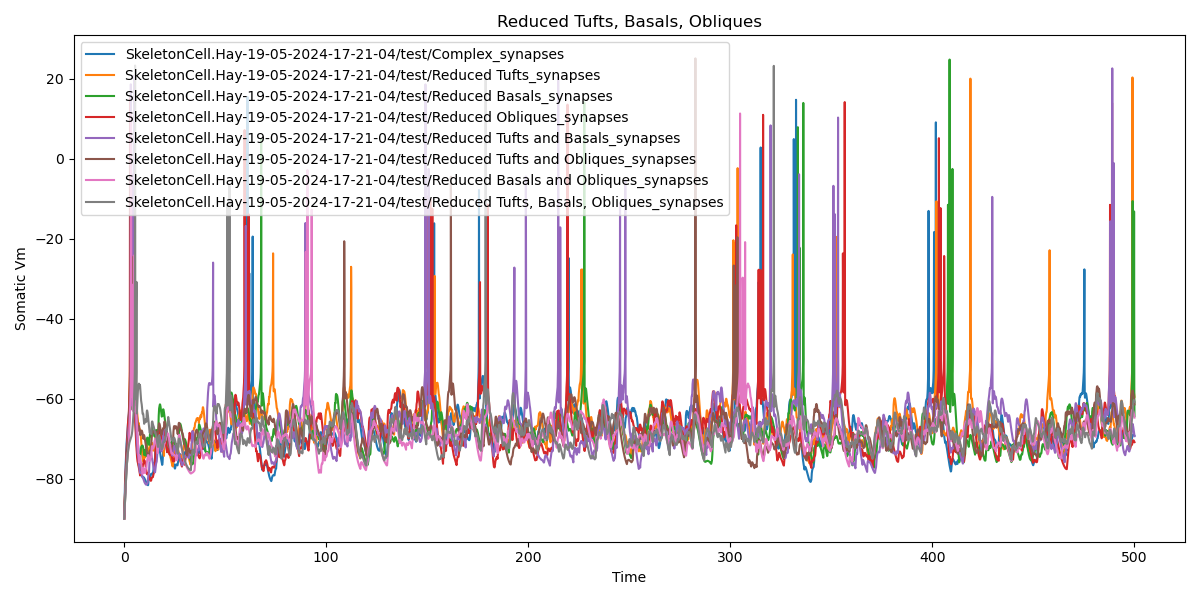

Correlation between Complex Cell and Reduced Tufts: 0.33028234776854376
Correlation between Complex Cell and Reduced Basals: 0.17904213221870957
Correlation between Complex Cell and Reduced Obliques: 0.5299982689312415
Correlation between Complex Cell and Reduced Tufts and Basals: 0.3660618316988577
Correlation between Complex Cell and Reduced Tufts and Obliques: 0.2452245205755796
Correlation between Complex Cell and Reduced Basals and Obliques: 0.29574530059758103
Correlation between Complex Cell and Reduced Tufts, Basals, Obliques: 0.09273316660524258


In [27]:
import shutil
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import pearsonr

# Adjust the parameters and initialize the cell structure here
root_path = parameters.path
FI_paths = []
parameters.h_tstop = 5000
parameters.h_i_duration = 1950
parameters.h_i_delay = 50
# amps = np.arange(-2, 2.1, 0.2)

# Prepare subplots: one for the somatic injection, another for the nexus injection
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

# Create a CSV file to store the results
csv_file_path = "FI_Curve_Data.csv"
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Cell Name", "Firing Rate (Hz)"])

    # Dictionary to store data for each cell
    cell_data = {}

    for ax in [axes]:
        for cell_name, cell in cells.items():
            firing_rates = []

            parameters.path = root_path + f"/{cell_name}_synapses"
            # os.mkdir(parameters.path)
            # with open(os.path.join(parameters.path, "parameters.pickle"), "wb") as file:
            #     pickle.dump(parameters, file)
            FI_paths.append(parameters.path)

            # Perform simulation
            print(f"simulating {cell_name}")
            sim.simulate(cell, parameters)

            # Read the voltage and spike data
            v = analysis.DataReader.read_data(parameters.path, "v", parameters=parameters)
            soma_spikes = analysis.DataReader.read_data(parameters.path, "soma_spikes", parameters=parameters)

            # Calculate the firing rate
            firing_rate = len(soma_spikes[0]) / (parameters.h_tstop / 1000)
            firing_rates.append(firing_rate)

            # Write the results to the CSV file
            writer.writerow([cell_name, firing_rate])

            # Store the data for later analysis
            cell_data[cell_name] = v[0]

            label = cell_name
            ax.plot(np.arange(0, len(v[0])) * parameters.h_dt, v[0], label=parameters.path)

        ax.set_title(cell_name)
        ax.set_xlabel('Time')
        ax.set_ylabel('Somatic Vm')
        # ax.set_xlim(0,2)
        ax.legend()

# Display the plots
plt.tight_layout()

# Save the figure to the current directory
plt.savefig("Synapses_Vm_no_mapping.png")  # You can specify other formats like 'pdf' by changing the file extension

plt.show()

# Clean up temporary directories
for FI_path in FI_paths:
    shutil.rmtree(FI_path)

# Compute correlations with the "Complex Cell" data
complex_cell_data = cell_data.get("Complex")
correlations = {}
if complex_cell_data is not None:
    for cell_name, data in cell_data.items():
        if cell_name != "Complex":
            correlation, _ = pearsonr(complex_cell_data, data)
            correlations[cell_name] = correlation

# Print correlations
for cell_name, correlation in correlations.items():
    print(f"Correlation between Complex Cell and {cell_name}: {correlation}")

# Optionally, store the data and correlations in a file
with open("Cell_Data_and_Correlations.pkl", "wb") as file:
    pickle.dump({"cell_data": cell_data, "correlations": correlations}, file)


In [28]:
cell_data.get('Complex')

array([-90.        , -88.9266772 , -86.07932928, ..., -69.06167741,
       -69.14629987, -69.24913349])

In [29]:
# Print correlations
for cell_name, correlation in correlations.items():
    print(f"Correlation between Complex Cell and {cell_name}: {correlation}")

Correlation between Complex Cell and Reduced Tufts: 0.33028234776854376
Correlation between Complex Cell and Reduced Basals: 0.17904213221870957
Correlation between Complex Cell and Reduced Obliques: 0.5299982689312415
Correlation between Complex Cell and Reduced Tufts and Basals: 0.3660618316988577
Correlation between Complex Cell and Reduced Tufts and Obliques: 0.2452245205755796
Correlation between Complex Cell and Reduced Basals and Obliques: 0.29574530059758103
Correlation between Complex Cell and Reduced Tufts, Basals, Obliques: 0.09273316660524258
